# FOR PICTURES

In [3]:
#dataset的用法 --- from numpy
import numpy as np
import tensorflow as tf
X = np.array([2013, 2014, 2015, 2016, 2017])
Y = np.array([12000, 14000, 15000, 16500, 17500])

dataset = tf.data.Dataset.from_tensor_slices((X, Y))
for x, y in dataset:
   print(x.numpy(), y.numpy())
for f0,f1 in dataset.take(1):
  print(f0)
  print(f1)


2013 12000
2014 14000
2015 15000
2016 16500
2017 17500
tf.Tensor(2013, shape=(), dtype=int32)
tf.Tensor(12000, shape=(), dtype=int32)


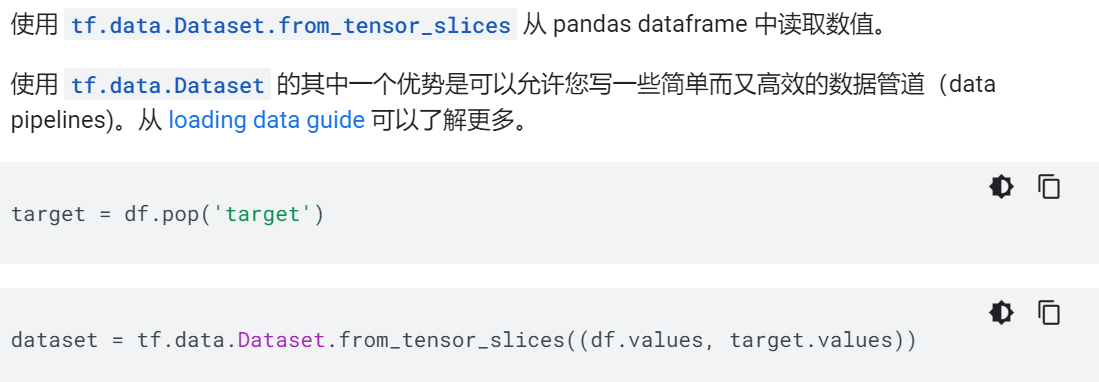


Dataset.map(f) ：对数据集中的每个元素应用函数 f ，得到一个新的数据集（这部分往往结合 tf.io 进行读写和解码文件， tf.image 进行图像处理）；


Dataset.shuffle(buffer_size) ：将数据集打乱（设定一个固定大小的缓冲区（Buffer），取出前 buffer_size 个元素放入，并从缓冲区中随机采样，采样后的数据用后续数据替换）；


Dataset.batch(batch_size) ：将数据集分成批次，即对每 batch_size 个元素，使用 tf.stack() 在第 0 维合并，成为一个元素。


Dataset.prefetch() ：预取出数据集中的若干个元素（可提升训练流程并行效率）。


除此以外，还有 Dataset.repeat() （重复数据集的元素）、 Dataset.reduce() （与 Map 相对的聚合操作）、 Dataset.take ()（截取数据集中的前若干个元素）等


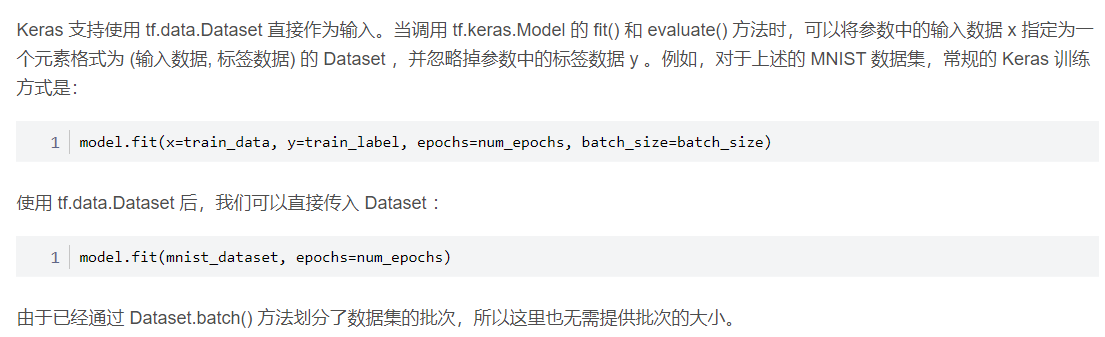

In [ ]:
import tensorflow as tf
from tensorflow.keras importmport datasets, layers, models
BATCH_SIZE = 100

def load_image(img_path, size=(32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) # for jpeg format
    img = tf.image.resize(img, size)/255.0
    return (img, label)


对于图片， i/o开销很大， 所以才需要用到并行 与 prefetch 的方法， 对于结构化的数据， 我们常用的预处理操作i/o开销很小。 当然， 长文本的话也是需要用到的。

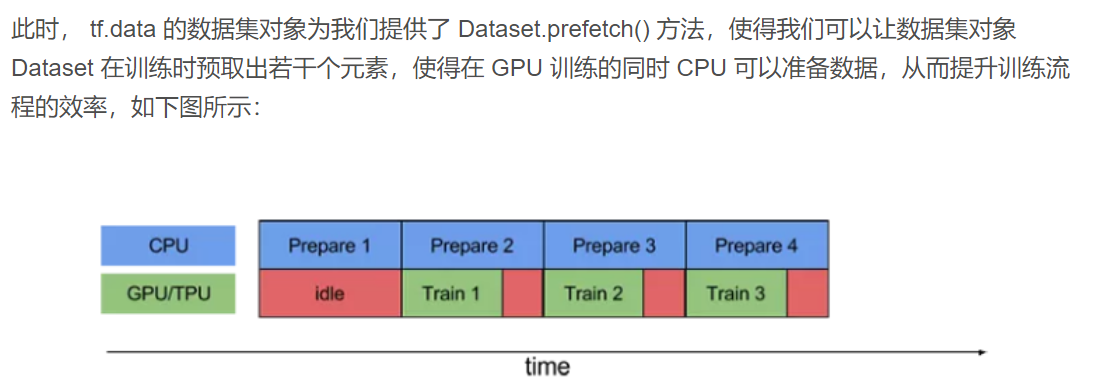

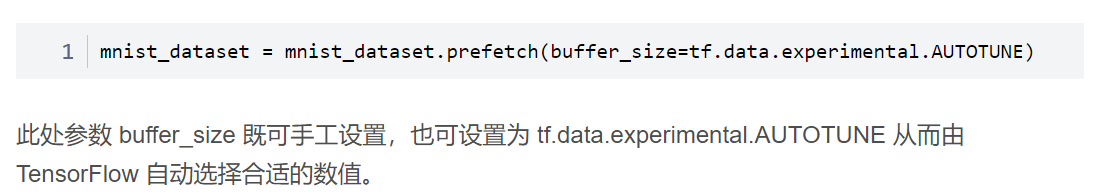

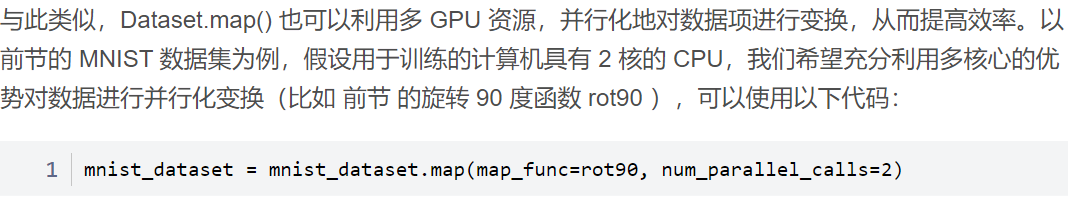

In [ ]:
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  
ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

In [ ]:
#model building process is the same as the structure_data_modeling code
import datetime
import os

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

In [ ]:
#evaluation
%load_ext tensorboard
#%tensorboard --logdir ./data/keras_model
from tensorboard import notebook
notebook.list() 
#在tensorboard中查看模型
notebook.start("--logdir ./data/keras_model")



In [ ]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory